In [1]:
import numpy as np
!pip install ta
!pip install yfinance
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import ta
import os
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout


def fetch_stock_data(symbol='BHARTIARTL.NS', start='2005-01-01', end='2025-01-01'):
    df = yf.download(symbol, start=start, end=end)

    close = df['Close'].squeeze()
    volume = df['Volume'].squeeze()
    high = df['High'].squeeze()
    low = df['Low'].squeeze()

    df['MA20'] = ta.trend.sma_indicator(close, window=20)
    df['MA50'] = ta.trend.sma_indicator(close, window=50)
    df['RSI'] = ta.momentum.rsi(close, window=14)
    df['Volume_MA20'] = volume.rolling(window=20).mean()
    df['ATR_14'] = ta.volatility.average_true_range(high, low, close, window=14)
    df['ADX_14'] = ta.trend.adx(high, low, close, window=14)
    df['BB_WIDTH'] = ta.volatility.bollinger_wband(close, window=20, window_dev=2)

    df.dropna(inplace=True)
    return df

def prepare_data(df):
    features = ['Close', 'MA20', 'MA50', 'RSI','Volume_MA20','ATR_14','ADX_14','BB_WIDTH']
    df = df[features]
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(df)

    total_len = len(data_scaled)
    test_size = int(total_len * 0.2)
    test_data = data_scaled[:test_size + 100]
    train_data = data_scaled[test_size:]

    return train_data, test_data, scaler

def create_sequences(data, window=100):
    x, y = [], []
    for i in range(window, len(data)):
        x.append(data[i - window:i])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

def predict_tomorrow_price(symbol, trained_models, window=100):
    df = fetch_stock_data(symbol)
    features = ['Close', 'MA20', 'MA50', 'RSI', 'Volume_MA20', 'ATR_14', 'ADX_14', 'BB_WIDTH']
    df = df[features].dropna()

    best_r2 = -np.inf
    best_prediction = None

    for entry in trained_models:
        model = entry['model']
        scaler = entry['scaler']
        try:
            data_scaled = scaler.transform(df)
        except:
            continue

        if len(data_scaled) < window:
            continue

        last_window = data_scaled[-window:]
        last_window = last_window.reshape(1, window, data_scaled.shape[1])

        y_pred_scaled = model.predict(last_window, verbose=0).flatten()[0]
        close_scale = scaler.scale_[0]
        close_min = scaler.min_[0]
        y_pred = y_pred_scaled / close_scale + close_min


        x_recent, y_true = create_sequences(data_scaled, window)
        y_pred_recent = model.predict(x_recent, verbose=0).flatten()
        y_true = np.array(y_true)

        y_pred_recent = y_pred_recent / close_scale + close_min
        y_true = y_true / close_scale + close_min
        r2 = r2_score(y_true, y_pred_recent)

        if r2 > best_r2:
            best_r2 = r2
            best_prediction = {
                'model_symbol': entry['symbol'],
                'predicted_price': y_pred,
                'r2': r2
            }

    if best_prediction:
        print(f" Tomorrow's predicted price for {symbol}: ₹{best_prediction['predicted_price']:.2f}")
        print(f"Used model trained on: {best_prediction['model_symbol']} | R² Score: {best_prediction['r2']:.4f}")
        return best_prediction['predicted_price']
    else:
        print(" No suitable model found for prediction.")
        return None



def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(60, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(80, return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(120))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


def train_and_save_models(symbols, model_dir='models'):
    os.makedirs(model_dir, exist_ok=True)
    for symbol in symbols:
        print(f"Training on {symbol}")
        df = fetch_stock_data(symbol)
        train_data, _, scaler = prepare_data(df)
        x_train, y_train = create_sequences(train_data)

        model = build_lstm_model(input_shape=(x_train.shape[1], x_train.shape[2]))
        model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=1)

        model.save(os.path.join(model_dir, f"{symbol}_model.h5"))
        with open(os.path.join(model_dir, f"{symbol}_scaler.pkl"), 'wb') as f:
            pickle.dump(scaler, f)


def load_models(symbols, model_dir='models'):
    models = []
    for symbol in symbols:
        model = load_model(os.path.join(model_dir, f"{symbol}_model.h5"))
        with open(os.path.join(model_dir, f"{symbol}_scaler.pkl"), 'rb') as f:
            scaler = pickle.load(f)
        models.append({'symbol': symbol, 'model': model, 'scaler': scaler})
    return models


def predict_new_stock_best(symbol, start, end, trained_models, window=100):
    df = fetch_stock_data(symbol, start, end)
    features = ['Close', 'MA20', 'MA50', 'RSI', 'Volume_MA20', 'ATR_14', 'ADX_14', 'BB_WIDTH']
    df = df[features].dropna()

    best_r2 = -np.inf
    best_result = None

    for entry in trained_models:
        model, scaler = entry['model'], entry['scaler']
        try:
            data_scaled = scaler.transform(df)
        except:
            continue

        x_new, y_true = create_sequences(data_scaled, window)
        y_pred_scaled = model.predict(x_new, verbose=1).flatten()

        close_scale = scaler.scale_[0]
        close_min = scaler.min_[0]
        y_pred = y_pred_scaled / close_scale + close_min
        y_true_rescaled = y_true / close_scale + close_min

        r2 = r2_score(y_true_rescaled, y_pred)

        if r2 > best_r2:
            best_r2 = r2
            best_result = {
                'symbol': entry['symbol'],
                'r2': r2,
                'y_pred': y_pred,
                'y_true': y_true_rescaled,
                'df': df
            }

    if best_result:
        print(f"Best Model: {best_result['symbol']} | R^2: {best_result['r2']:.4f}")
        plt.figure(figsize=(14, 7))
        plt.plot(best_result['y_true'], label='Actual')
        plt.plot(best_result['y_pred'], label='Predicted')
        plt.title(f"Prediction for {symbol} using best model")
        plt.legend()
        plt.show()

        return best_result['y_pred'], best_result['y_true'], best_result['df']
    else:
        print("No suitable model found.")
        return None, None, None


if __name__ == "__main__":
    group_less = ['MAXHEALTH.NS', 'IDEA.NS', 'ITC.NS', 'TATAMOTORS.NS']
    group_mid = ['ICICIBANK.NS', 'HDFCBANK.NS','SIEMENS.NS', 'HEROMOTOCO.NS']
    group_more = [ 'MRF.NS', 'BAJFINANCE.NS', 'POWERINDIA.NS', 'PAGEIND.NS']

    all_symbols = list(set(group_less + group_more + group_mid))
    train_and_save_models(all_symbols)

    # # To predict for stock using X models
    # x_models = load_models(group_less)
    # predict_new_stock_best("HCLTECH.NS", "2020-01-01", "2025-01-01", trained_models=x_models)

    # # To predict for stock using Y models
    # y_models = load_models(group_more)
    # predict_new_stock_best("BPCL.NS", "2020-01-01", "2025-01-01", trained_models=y_models)


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=21449da52d0bedd3423713a49628c3f0571590f1be53065053ed78b9de0ced6c
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
Training on TATAMOTORS.NS
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0128
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0026
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0025
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0022
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0018
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0016
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0016
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0014
Epoch 9/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0015
Epoch 10/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0012
Epoch 11/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0011
Epoch 12/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0012
Epoch 13/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0011
Epoch 14/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0013
Epoch 15/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s

Training on PAGEIND.NS


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0324
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0044
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0039
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0035
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0035
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0026
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0029
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0027
Epoch 9/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0028
Epoch 10/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0027
Epoch 11/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0022
Epoch 12/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0023
Epoch 13/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0021
Epoch 14/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0026
Epoch 15/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s

Training on BAJFINANCE.NS


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0339
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0058
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0043
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0037
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0042
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0046
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0032
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0030
Epoch 9/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0026
Epoch 10/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0027
Epoch 11/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0025
Epoch 12/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0024
Epoch 13/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0026
Epoch 14/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0023
Epoch 15/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s

Training on MRF.NS


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 0.0215
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0032
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0027
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0025
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0025
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0021
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0020
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0017
Epoch 9/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0018
Epoch 10/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0018
Epoch 11/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0017
Epoch 12/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0016
Epoch 13/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0016
Epoch 14/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0016
Epoch 15/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s

Training on IDEA.NS


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0303
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0051
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0040
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0037
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0035
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0027
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0027
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0030
Epoch 9/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0026
Epoch 10/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0023
Epoch 11/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0023
Epoch 12/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0028
Epoch 13/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0026
Epoch 14/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0022
Epoch 15/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training on MAXHEALTH.NS
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0796
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0105
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0080
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0055
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0073
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0056
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0050
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0057
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0048
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0052
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0042
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0047
Epoch 13/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0053
Epoch 14/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0041
Epoch 15/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms

Training on HEROMOTOCO.NS


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0191
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0030
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0025
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0026
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0017
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0018
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0018
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0016
Epoch 9/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0016
Epoch 10/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0014
Epoch 11/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0012
Epoch 12/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0013
Epoch 13/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0012
Epoch 14/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 9.5868e-04
Epoch 15/50
119/119 ━━━━━━━━━━━━━━━━━━━

Training on HDFCBANK.NS


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0274
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0054
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0040
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0038
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0036
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0033
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0030
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0026
Epoch 9/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0029
Epoch 10/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0027
Epoch 11/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0025
Epoch 12/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0022
Epoch 13/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0022
Epoch 14/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0022
Epoch 15/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s

Training on SIEMENS.NS


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0111
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0022
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0016
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0015
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0018
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0014
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0014
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0013
Epoch 9/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0019
Epoch 10/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0012
Epoch 11/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0010
Epoch 12/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0010
Epoch 13/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0011
Epoch 14/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0011
Epoch 15/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s

Training on POWERINDIA.NS


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0427
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0114
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0059
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0057
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0047
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0058
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0047
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0064
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0046
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0040
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0038
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0043
Epoch 13/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0037
Epoch 14/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0040
Epoch 15/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0035
Epoc

Training on ICICIBANK.NS


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0137
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0032
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0026
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0020
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0021
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0019
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0016
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0017
Epoch 9/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0015
Epoch 10/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0016
Epoch 11/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0014
Epoch 12/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0015
Epoch 13/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0012
Epoch 14/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0014
Epoch 15/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s

Training on ITC.NS


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0241
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0036
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0036
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0026
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0022
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0026
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0023
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0020
Epoch 9/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0015
Epoch 10/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0017
Epoch 11/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0017
Epoch 12/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0014
Epoch 13/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0013
Epoch 14/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0014
Epoch 15/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s

[*********************100%***********************]  1 of 1 completed


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Best Model: TATAMOTORS.NS | R^2: 0.9879


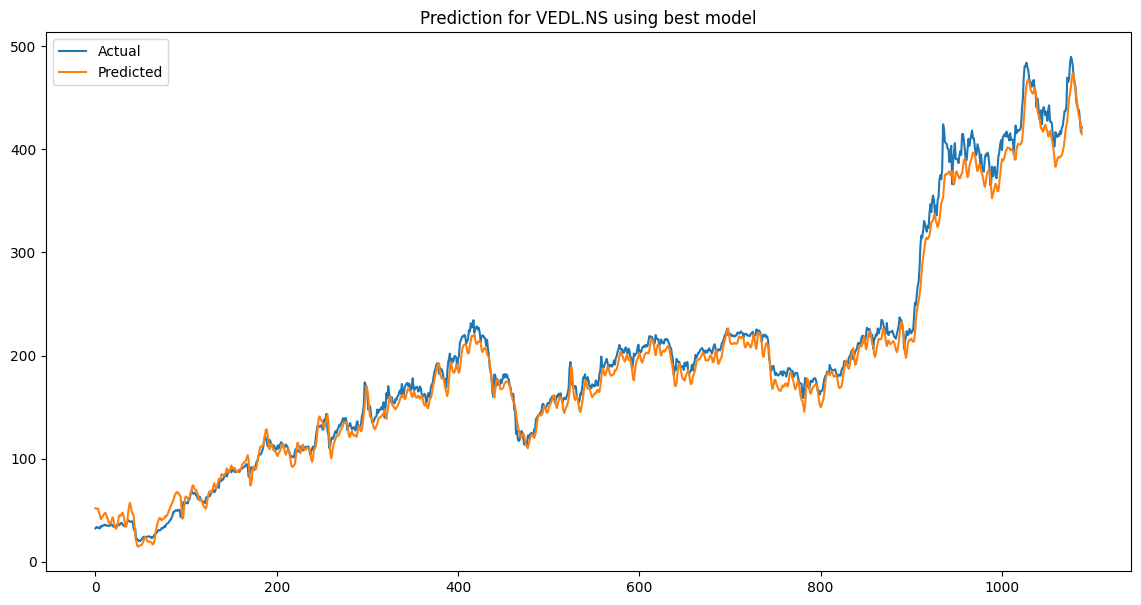

(array([ 51.76087832,  51.45254294,  51.37492063, ..., 428.79292504,
        423.58201671, 414.80337657]),
 array([ 32.28027919,  33.35548213,  33.53468135, ..., 428.3655453 ,
        416.91553309, 421.7155514 ]),
 Price            Close        MA20        MA50        RSI  Volume_MA20  \
 Ticker         VEDL.NS                                                   
 Date                                                                     
 2020-03-12   35.773022   54.061389   60.948813  16.622345  22556158.30   
 2020-03-13   37.654636   52.876992   60.361946  21.998694  24344956.55   
 2020-03-16   33.533012   51.465928   59.650611  19.094252  25692761.70   
 2020-03-17   33.600204   50.088560   58.955354  19.281352  27017333.80   
 2020-03-18   32.681801   48.643603   58.304133  18.646613  28121789.50   
 ...                ...         ...         ...        ...          ...   
 2024-12-24  462.100006  476.396181  462.625001  43.933502  11655322.75   
 2024-12-26  460.450012  477.529073 

In [5]:
nifty_50_symbols = [
          "ADANIENT.NS", "ADANIPORTS.NS", "APOLLOHOSP.NS", "ASIANPAINT.NS", "AXISBANK.NS",
          "BAJAJ-AUTO.NS", "BAJFINANCE.NS", "BAJAJFINSV.NS", "BPCL.NS", "BHARTIARTL.NS",
          "BRITANNIA.NS", "CIPLA.NS", "COALINDIA.NS", "DIVISLAB.NS", "DRREDDY.NS",
          "EICHERMOT.NS", "GRASIM.NS", "HCLTECH.NS", "HDFCBANK.NS", "HEROMOTOCO.NS",
          "HINDALCO.NS", "HINDUNILVR.NS", "ICICIBANK.NS", "ITC.NS", "INDUSINDBK.NS",
          "INFY.NS", "JSWSTEEL.NS", "KOTAKBANK.NS", "LT.NS", "M&M.NS",
          "MARUTI.NS", "NTPC.NS", "NESTLEIND.NS", "ONGC.NS", "POWERGRID.NS",
          "RELIANCE.NS", "SBILIFE.NS", "SBIN.NS", "SUNPHARMA.NS", "TCS.NS",
          "TATACONSUM.NS", "TATAMOTORS.NS", "TATASTEEL.NS", "TECHM.NS", "TITAN.NS",
          "UPL.NS", "ULTRACEMCO.NS", "WIPRO.NS"
      ]

y_models = load_models(group_more)
x_models = load_models(group_less)
z_models= load_models(group_mid)

for symbol in nifty_50_symbols:
  prices_dict = yf.download(symbol, period="1d")['Close'].iloc[-1].to_dict()
  price = list(prices_dict.values())[0] # Extract the price value from the dictionary

  if price <= 800 :
    predict_new_stock_best(symbol, "2020-01-01", "2025-01-01", trained_models=x_models)

  elif price > 800 and price <= 3000 :
    predict_new_stock_best(symbol, "2020-01-01", "2025-01-01", trained_models=z_models)

  else :
    predict_new_stock_best(symbol, "2020-01-01", "2025-01-01", trained_models=y_models)

Output hidden; open in https://colab.research.google.com to view.